The workflow for a data science project will follow these lines:

1. Get and explore the data
2. Build a model 
3. Train the model
4. Save and predict

## 1. Get and Explore the Data
The first step can take quite some time; data quality is often something that needs to be checked, and correlations between data should often be explored and visualized.

This step can be a full project on its own: you clean the data, make sure you can access it properly, and create visualizations and hypothesis to gain insight into the data that can be shown in a dashboard.

The insight in the data is an essential ingredient for deciding on a model.

## 2. Build a model
Based on domain knowledge and a first exploration of the data, a model can be selected.

Sometimes, the relation between features and outcome is very obvious. You might have features that
correlate very high with the outcome variable, and a domain expert confirms that the correlations make sense.

If this is the case, you can often build a simple model. If you expect to have non-linear and complex interactions between the features,
you could use a model that works with non-linear data like a SVM plus kernel, or a random forest.

If you have enough data (as a rule of thumb, a lower threshold of 1000 observations) you can consider a neural network architecture.
If the expected complexity of the data is low, you can use a relative small network.
If you have lots and lots of data with a high complexity, you should consider to increase the complexity of your model too.

How you can build a model, and what suitable models are for different datatypes and situations, will be the subject of the whole course.

## 3. Train the model
Once you created a model, it hasnt learned anything yet. The model must be trained to learn the right connections, a bit like a baby that has to learn about what works and what doesn't.

In this notebook, I will introduce you to PyTorch. Another high level library is Tensorflow, which is used a lot too.
While the interface is comparable, the Tensorflow syntax is a bit more high-level. While this can be an advantage, 
it also has a downside: at the moment you ever need to dive a bit deeper into the architecture itself, it is much harder to
add something new with TensorFlow, compared to PyTorch.

## 4. Save and predict
Finally, you will want to use the trained model to predict new observations.

# Load the data
We will use the fashion MNIST dataset. You will find this dataset a lot in machine learning tutorials. It are small (28x28) images of clothing.

In [1]:
import sys
sys.path.insert(0, "../..")
from src.models import train_model

2022-04-25 20:26:44.029719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 20:26:44.029755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from torchvision.transforms import ToTensor
from torchvision import datasets

from pathlib import Path
datadir = "../../data/raw/"

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root=datadir,
    train=True,
    download=True,

    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root=datadir,
    train=False,
    download=True,
    transform=ToTensor(),
)

We now have `torch.datasets`. They implement at minimum an `.__getitem__` and `.__len__` function.

In [3]:
type(training_data)

torchvision.datasets.mnist.FashionMNIST

In [4]:
len(training_data)

60000

To get the data, we can use the __getitem__ method by calling an index, just like you would do with a list or array.

In [5]:
x = training_data[0]
type(x), type(x[0]), type(x[1])

(tuple, torch.Tensor, int)

This is equivalent to this:

In [6]:
x = training_data.__getitem__(0)

X is a tuple. We can check the length:

In [7]:
len(x)

2

We can get the 0th item, which is the image (tensor). The other item is the label (int)

In [8]:
img = x[0]
img.shape

torch.Size([1, 28, 28])

You can see the image has a channel-first convention: it is a 28x28 pixel image, and it has 1 channel (grey). Look into the official documentation if you want to know more about datasets and how to build your own: [docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Ok, we want to batch this into a dataloader. From the documentation:

> The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval

In [9]:
from torch.utils.data import DataLoader
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Why is the length of the dataloader different from the dataset? We had 60000 items before...

In [10]:
len(train_dataloader), len(test_dataloader)

(938, 157)

In [11]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

So, what do we see here? Our datashape has four dimensions:

- 64: this is the batch size. Every batch has 64 observations; in this case 64 images
- 1: this is the channel. Colorimages typically have 3 channels. Our images have just one color, and thus 1 channel. So images can have more channels (e.g. infrared etc)
- (28,28) : this is the actual image, with dimensions 28x28

Lets visualize the first example, the first image:

In [12]:
img = X[0]
img.shape

torch.Size([1, 28, 28])

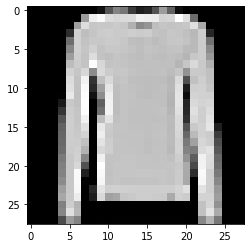

In [13]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap="gray")

# Create a model

In [14]:
import torch
from torch import nn

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Hopefully, you recognize the setup from the `linearmodel` notebook. 

- We will `Flatten` the image. That means we will transform our (64, 1, 28, 28) data into (64, 784) shaped data. What we do here, is flattening the image into a one dimensional vector.
- We have a stack of hidden layers. These are essentially dotproducts. Our vector of 784 (28*28) elements is transformed into 512 elements, and then into 10 elements because we have 10 classes.
- in between the linear transformations you can see the activation functions,here a `ReLu` 
- The `forward` method is what is called during training. This gives you control over the flow of information: it is easy to create some parallel flow of data if you want to do something like that.

# Optimizer

We need an optimizer. We will dive into this in later lessons.

For now, it is enough to know this:

Your model makes a prediction. But how does the model know if it is right, or wrong?
And, more specific: how does the model know which weights it needs to modify in order

In [15]:
import torch.optim as optim
loss_fn = torch.nn.CrossEntropyLoss()

# Learn the weights

In [16]:
len(train_dataloader), len(train_dataloader.dataset)

(938, 60000)

In [17]:
log_dir="../../models/test"

In [ ]:
model = train_model.trainloop(
    epochs=5,
    model=model,
    optimizer=optim.Adam,
    learning_rate=1e-3,
    log_dir=log_dir,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    eval_steps=50,
)


# Save the model

In [29]:
model_dir = Path("../../models") 
model_dir.exists()

True

In [30]:
modelpath = model_dir / "trained_model"
torch.save(model, modelpath)

# load the model

In [31]:
loaded_model = torch.load(modelpath)

Get a batch $X$, $y$ and make a prediction $\hat{y}$

In [32]:
X, y = next(iter(test_dataloader))
yhat = loaded_model(X)
yhat.shape

torch.Size([64, 10])

Check the accuracy:
- for every example we have 10 numbers
- the location with the highest value is the prediction
- we can get the index with `argmax` over dimension 1
- we compare that index with the original number
- This gives us a count of all the correct predictions
- dividing that through the total length gives us the accuracy percentage. 

In [33]:
accuracy = (yhat.argmax(dim=1) == y).sum() / len(y)
accuracy.item() * 100

92.1875

Note that this is the accuracy for a single batch! 
Get another batch by running next() in the cell above, and calculate the accuracy again.

# Clean up

In [34]:
cleanup = True
from src.data import data_tools
# to remove the trained model
if cleanup:
    modelpath.unlink()
    data_tools.clean_dir(log_dir)

2022-04-25 18:44:37.145 | INFO     | src.data.data_tools:clean_dir:121 - Clean out {dir}
